In [3]:
pip install pennylane

     ---------------------------------------- 1.5/1.5 MB 651.0 kB/s eta 0:00:00
     -------------------------------------- 49.3/49.3 kB 830.0 kB/s eta 0:00:00
     ---------------------------------------- 49.9/49.9 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 634.3 kB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 591.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [101]:
#Benchmarking Variational Quantum State Diagonalization Algorithm

In [1]:
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [8]:
m = 2
n = 2*m
def test_prep(m):
    for i in range(2*m):
        qml.Hadamard(i)
#    return [qml.expval(qml.PauliZ(i)) for i in range(2*m)]
drawer = qml.draw(test_prep)
print(drawer(2))
#test_prep(m)

0: ──H─┤  
1: ──H─┤  
2: ──H─┤  
3: ──H─┤  


In [14]:
#TODO
#Make angles equal in the ith subsystem of registers 1 and 2
#param needs to be specifiable with m angles
param = [0, 1, 2, 3]

def ansatz(param, m):
    for i in range(2*m):
        qml.RY(param[i], wires = i)
        qml.RX(np.pi/2, wires = i)
drawer = qml.draw(ansatz(param, 2))
print(drawer)

<function draw.<locals>.wrapper at 0x000002431BAA2560>


In [15]:
def cost_fun(m):
    for i in range(m):
        qml.CNOT(wires = [i,i+m])
drawer = qml.draw(cost_fun)
print(drawer(2))

0: ─╭●─┤  
2: ─╰X─┤  
1: ─╭●─┤  
3: ─╰X─┤  


In [17]:
s = 1000
m = 2
n = 2*m
dev = qml.device("default.qubit", wires = n, shots = s)
@qml.qnode(dev, interface = "autograd")
def circuit(param, m):
    test_prep(m)
    ansatz(param, m)
    cost_fun(m)
    return qml.probs(wires = [i for i in range(2*m)])

In [18]:
def VQSD(param):
    return circuit(param, m)[0]

In [7]:
t = []
for i in range(n):
    t.append(0.0)
theta = np.array(t, requires_grad=True)
print(theta)

[0. 0. 0. 0.]


In [24]:
diag = [VQSD(theta)]
print(diag)

[0.059]


In [25]:
# store the values of the circuit parameter
angle = [theta]
print(angle)
#len(angle)

[tensor([ 2.00000000e-04, -2.40000000e-03,  2.20000000e-03,
        -2.22044605e-20], requires_grad=True)]


In [28]:
###To Do
#Figure out why the energy stays roughly constant

opt = qml.GradientDescentOptimizer(stepsize=0.4)
max_iterations = 1000
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_diag = opt.step_and_cost(VQSD, theta)

    diag.append(VQSD(theta))
    angle.append(theta)

    conv = np.abs(diag[-1] - prev_diag)

    if n % 2 == 0:
        print(f"Step = {n},  Diagonality = {diag[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {diag[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Diagonality = 0.05200000 Ha
Step = 2,  Diagonality = 0.05500000 Ha
Step = 4,  Diagonality = 0.06300000 Ha
Step = 6,  Diagonality = 0.05100000 Ha
Step = 8,  Diagonality = 0.08600000 Ha
Step = 10,  Diagonality = 0.06000000 Ha
Step = 12,  Diagonality = 0.05100000 Ha
Step = 14,  Diagonality = 0.08000000 Ha
Step = 16,  Diagonality = 0.06800000 Ha
Step = 18,  Diagonality = 0.06700000 Ha
Step = 20,  Diagonality = 0.05700000 Ha
Step = 22,  Diagonality = 0.06500000 Ha
Step = 24,  Diagonality = 0.05900000 Ha
Step = 26,  Diagonality = 0.06700000 Ha

Final value of the ground-state energy = 0.06700000 Ha


TypeError: unsupported format string passed to tensor.__format__

ValueError: x and y must have same first dimension, but have shapes (28,) and (38,)

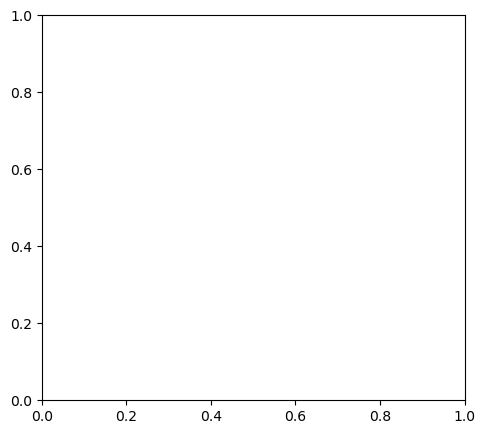

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), diag, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()